# A/B Testing Masterclass: Advanced Techniques at Scale
## Criteo Uplift Modeling Analysis

---

## 🎯 Building on the Lifecycle: Where Judgment Matters Most

**The first notebook covered the fundamentals—the experimentation lifecycle.** This notebook builds on that foundation with advanced techniques for complex, real-world scenarios.

### Why Advanced Techniques Matter

In the real world, experiments rarely follow the textbook pattern:
- **Assumptions break down** (data is messy, distributions are weird)
- **There's no single correct answer** (multiple valid approaches, different trade-offs)
- **Judgment matters more than formulas** (knowing when to use which technique)

This is where strong candidates differentiate themselves in interviews. Anyone can run a t-test. Fewer can explain when CUPED is appropriate vs. CUPAC, or articulate why they'd use X-Learner for heterogeneous treatment effects.

### What You'll Learn

| Technique | When to Use It | The Trade-off |
|-----------|----------------|---------------|
| **Designed Imbalance** | When you need more control data | Power vs. implementation risk |
| **CUPAC** | Large samples with rich covariates | Complexity vs. variance reduction |
| **X-Learner (HTE)** | Personalization, targeting decisions | Interpretability vs. granularity |
| **Sequential Testing** | Need for early stopping | Type I error control vs. flexibility |

**Key Principle**: These techniques are powerful, but the hardest part is knowing **when** to use them.

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Handle designed imbalance** in SRM checks (15/85 vs. 50/50)
2. **Implement CUPAC** (ML-enhanced variance reduction) and explain when it beats CUPED
3. **Detect heterogeneous treatment effects** and explain their business implications
4. **Apply sequential testing** for early stopping while controlling error rates
5. **Make judgment calls** when there's no single correct answer

---

## The Business Context

**Criteo** is a major ad tech company serving billions of ads daily. This dataset (13.9M observations) comes from their uplift modeling research—predicting WHO will respond positively to ads.

### Why Large-Scale Experiments Are Different

| At Small Scale | At Large Scale |
|----------------|----------------|
| Need bigger effects to detect | Can detect tiny effects |
| Simple methods work fine | Need sophisticated variance reduction |
| Average treatment effect is enough | Heterogeneous effects become interesting |
| Wait for experiment to finish | Early stopping becomes valuable |

### 💡 Interview Insight: The Scale Paradox

Large samples create a paradox:
- **Pro**: You can detect tiny effects (1% lift at billion-dollar scale = millions)
- **Con**: Tiny effects become "statistically significant" even when practically meaningless

This is why **practical significance** becomes even more important at scale.

### The Metrics

- **Visit Rate**: Did the user visit the website after seeing the ad?
- **Conversion Rate**: Did the user make a purchase?

---

## Setup and Data Loading

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

# A/B Testing modules
from ab_testing.data import loaders
from ab_testing.core import randomization, frequentist
from ab_testing.variance_reduction import cupac
from ab_testing.advanced import hte, sequential
from ab_testing.diagnostics import guardrails

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("✓ Modules loaded successfully")

✓ Modules loaded successfully


### Understanding Sampling Strategy

The full Criteo dataset has **13.9 million observations**. For learning purposes, we'll use a sample:

| Sample | Rows | Use Case | Memory |
|--------|------|----------|--------|
| 0.1% | ~14K | Quick testing | ~10 MB |
| 1% | ~139K | Development | ~100 MB |
| 10% | ~1.4M | Production analysis | ~1 GB |
| 100% | ~13.9M | Final analysis | ~10 GB |

### 💡 Interview Insight: Sampling Trade-offs

*"How would you approach analyzing a dataset with 100M rows?"*

**Weak answer**: *"Load it all into memory."*

**Strong answer**: *"I'd start with a small sample (0.1-1%) to develop and validate my code, then scale up for final analysis. For production, I'd use stratified sampling to maintain group proportions. If the full dataset is essential (e.g., for rare events), I'd use chunked processing or distributed computing."*

---

In [2]:
# Load with 1% sample for learning (balance between speed and realistic size)
SAMPLE_FRAC = 0.01

df = loaders.load_criteo_uplift(sample_frac=SAMPLE_FRAC)
print(f"Dataset loaded: {len(df):,} observations ({SAMPLE_FRAC:.1%} of full dataset)")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded: 139,796 observations (1.0% of full dataset)

Columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'visit', 'treatment', 'conversion']


In [3]:
# Understand group allocation
print("Group Distribution")
print("=" * 50)
print(df['treatment'].value_counts(normalize=True))
print(f"\nNote: This is a ~15/85 split (not 50/50)")
print("This is INTENTIONAL - designed imbalance.")

Group Distribution
treatment
1    0.849438
0    0.150562
Name: proportion, dtype: Float64

Note: This is a ~15/85 split (not 50/50)
This is INTENTIONAL - designed imbalance.


---

## Phase 1: SRM Check with Designed Imbalance

### 💡 Interview Insight: Not All Imbalance is Bad

In the Cookie Cats notebook, we expected 50/50 allocation. Here, we have ~15/85 (treatment/control). Is this SRM?

**No—this is designed imbalance.**

### Why Use Unequal Allocation?

| Reason | Explanation |
|--------|-------------|
| **Risk mitigation** | Expose fewer users to potentially bad treatment |
| **Baseline data** | More control data for variance reduction |
| **Business constraints** | Can't afford to treat 50% of users |
| **Uplift modeling** | Need more control to estimate counterfactuals |

**The key question**: Does the actual allocation match the **intended** allocation?

---

In [4]:
# Calculate actual allocation
control_count = (df['treatment'] == 0).sum()
treatment_count = (df['treatment'] == 1).sum()
total = len(df)

actual_treatment_ratio = treatment_count / total

# The INTENDED allocation is ~15% treatment, 85% control
INTENDED_TREATMENT_RATIO = 0.15

print("Allocation Check")
print("=" * 50)
print(f"Control: {control_count:,} ({(control_count/total):.2%})")
print(f"Treatment: {treatment_count:,} ({actual_treatment_ratio:.2%})")
print(f"\nIntended treatment ratio: {INTENDED_TREATMENT_RATIO:.0%}")
print(f"Actual treatment ratio: {actual_treatment_ratio:.2%}")
print(f"Deviation: {abs(actual_treatment_ratio - INTENDED_TREATMENT_RATIO):.2%}")

Allocation Check
Control: 21,048 (15.06%)
Treatment: 118,748 (84.94%)

Intended treatment ratio: 15%
Actual treatment ratio: 84.94%
Deviation: 69.94%


In [5]:
# Run SRM check with the CORRECT expected ratio
# For 15% treatment / 85% control, we pass expected_ratio as [control_ratio, treatment_ratio]
srm_result = randomization.srm_check(
    n_control=control_count,
    n_treatment=treatment_count,
    expected_ratio=[1 - INTENDED_TREATMENT_RATIO, INTENDED_TREATMENT_RATIO],  # [0.85, 0.15]
    alpha=0.01
)

print("SRM Check (Against Intended 15/85 Allocation)")
print("=" * 50)
print(f"P-value: {srm_result['p_value']:.6f}")
print(f"SRM Detected: {srm_result['srm_detected']}")
print(f"Practical Significance: {srm_result['practical_significant']}")

if srm_result['srm_severe']:
    print("\n⚠️  SEVERE SRM: Allocation significantly deviates from intended 15/85 split.")
elif srm_result['srm_warning']:
    print("\n⚠️  WARNING: Statistical but not practical significance.")
else:
    print("\n✓ Allocation matches intended design.")

SRM Check (Against Intended 15/85 Allocation)
P-value: 0.000000
SRM Detected: True
Practical Significance: True

⚠️  SEVERE SRM: Allocation significantly deviates from intended 15/85 split.


### 💡 Interview Insight: The SRM Framework

When asked about SRM in interviews, demonstrate you understand the full picture:

1. **First, ask about intended allocation.** Don't assume 50/50.
2. **Check both statistical and practical significance.** Large samples make everything significant.
3. **Different contexts, different actions:**
   - RCT with severe SRM → Stop analysis
   - Observational data → Note limitations, proceed with caution
   - Designed imbalance → Compare against intended ratio

---

## Phase 2: Primary Metric Analysis (Visit Rate)

In [6]:
# Prepare data
control_df = df[df['treatment'] == 0]
treatment_df = df[df['treatment'] == 1]

control_visit = control_df['visit'].values
treatment_visit = treatment_df['visit'].values

# z_test_proportions expects counts, not arrays
# x = number of successes (visits), n = total sample size
x_control = control_visit.sum()
n_control = len(control_visit)
x_treatment = treatment_visit.sum()
n_treatment = len(treatment_visit)

# Basic z-test
visit_result = frequentist.z_test_proportions(
    x_control=x_control,
    n_control=n_control,
    x_treatment=x_treatment,
    n_treatment=n_treatment,
    alpha=0.05
)

print("Visit Rate Analysis (Basic Z-Test)")
print("=" * 50)
print(f"\nControl:   {visit_result['p_control']:.4f} ({visit_result['p_control']:.2%})")
print(f"Treatment: {visit_result['p_treatment']:.4f} ({visit_result['p_treatment']:.2%})")
print(f"\nAbsolute lift: {visit_result['absolute_lift']:.4f}")
print(f"Relative lift: {visit_result['relative_lift']:.2%}")
print(f"\n95% CI: [{visit_result['ci_lower']:.4f}, {visit_result['ci_upper']:.4f}]")
print(f"P-value: {visit_result['p_value']:.6f}")
print(f"\nSignificant: {visit_result['significant']}")

Visit Rate Analysis (Basic Z-Test)

Control:   0.0397 (3.97%)
Treatment: 0.0486 (4.86%)

Absolute lift: 0.0089
Relative lift: 22.55%

95% CI: [0.0060, 0.0119]
P-value: 0.000000

Significant: True


---

## Phase 3: CUPAC (ML-Enhanced Variance Reduction)

### 💡 Interview Insight: CUPED vs. CUPAC—When to Use Which

This is a common interview question. Here's the framework:

| Method | How It Works | When to Use |
|--------|--------------|-------------|
| **CUPED** | Linear adjustment using pre-experiment metric | Good baseline, simple, interpretable |
| **CUPAC** | ML model predicts outcome, use residuals | Large samples, rich covariates, non-linear relationships |

### The Math (Simplified)

**CUPED** (Controlled-experiment Using Pre-Experiment Data):
- Use pre-experiment value of the same metric
- Adjust: Y_adjusted = Y - θ × (X - mean(X))
- θ = Cov(Y, X) / Var(X)

**CUPAC** (Controlled-experiment Using Predictors And Covariates):
- Use ML model to predict Y from covariates
- Adjust: Y_adjusted = Y - prediction
- More flexible, captures non-linear relationships

### The Trade-off

| CUPED | CUPAC |
|-------|-------|
| ✅ Simple, interpretable | ✅ More variance reduction |
| ✅ Works with little data | ✅ Uses rich covariate information |
| ❌ Only linear adjustment | ❌ Requires large samples |
| ❌ One covariate | ❌ Model complexity |

**Industry Practice**:
- Netflix: Uses CUPAC on most experiments (40%+ variance reduction typical)
- DoorDash: Pioneered CUPAC methodology
- Spotify: Uses CUPED as baseline (~30% average reduction)

---

In [7]:
# CUPAC requires covariates - let's see what we have
print("Available Covariates")
print("=" * 50)
covariate_cols = [col for col in df.columns if col not in ['treatment', 'visit', 'conversion']]
print(f"\nCovariate columns: {covariate_cols[:10]}...")  # Show first 10
print(f"Total covariates: {len(covariate_cols)}")

Available Covariates

Covariate columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']...
Total covariates: 12


In [8]:
# Run CUPAC analysis
# Identify feature columns (all columns except treatment and outcomes)
feature_cols = [col for col in df.columns if col not in ['treatment', 'visit', 'conversion', 'exposure']]

# Keep combined variables for later use (X-Learner needs these)
X = df[feature_cols].values
y = df['visit'].values
treatment = df['treatment'].values

# Split data by treatment group for CUPAC
# cupac_ab_test expects pre-split data: y_control, y_treatment, X_control, X_treatment
control_mask = df['treatment'] == 0
treatment_mask = df['treatment'] == 1

y_control = df.loc[control_mask, 'visit'].values
y_treatment = df.loc[treatment_mask, 'visit'].values
X_control = df.loc[control_mask, feature_cols].values
X_treatment = df.loc[treatment_mask, feature_cols].values

# Run CUPAC with correct signature
cupac_result = cupac.cupac_ab_test(
    y_control=y_control,
    y_treatment=y_treatment,
    X_control=X_control,
    X_treatment=X_treatment,
    model_type='gbm',
    alpha=0.05,
    random_state=42
)

print("CUPAC Analysis Results")
print("=" * 50)
# Use correct result keys: effect_adjusted, se_adjusted, ci_adjusted
print(f"\nTreatment effect: {cupac_result['effect_adjusted']:.6f}")
print(f"Standard error:   {cupac_result['se_adjusted']:.6f}")
print(f"\n95% CI: [{cupac_result['ci_adjusted'][0]:.6f}, {cupac_result['ci_adjusted'][1]:.6f}]")
print(f"P-value: {cupac_result['p_value']:.6f}")
print(f"\nSignificant: {cupac_result['significant']}")
print(f"\nVariance reduction: {cupac_result['var_reduction']:.1%}")
print(f"Model R²: {cupac_result['model_r2']:.4f}")

CUPAC Analysis Results

Treatment effect: 0.006234
Standard error:   0.001255

95% CI: [0.003774, 0.008694]
P-value: 0.000001

Significant: True

Variance reduction: 30.8%
Model R²: 0.2772


In [9]:
# Compare variance reduction
print("Variance Reduction Comparison")
print("=" * 50)

# Standard error from z-test CI
basic_se = (visit_result['ci_upper'] - visit_result['ci_lower']) / (2 * 1.96)
# Use correct key: se_adjusted
cupac_se = cupac_result['se_adjusted']

variance_reduction = 1 - (cupac_se ** 2) / (basic_se ** 2)

print(f"\nBasic z-test SE:  {basic_se:.6f}")
print(f"CUPAC SE:         {cupac_se:.6f}")
print(f"\nVariance reduction: {variance_reduction:.1%}")

if variance_reduction > 0.3:
    print("\n✓ Excellent variance reduction (>30%)")
    print("  This means we'd need ~{:.0f}% fewer samples for same precision.".format(variance_reduction * 100))
elif variance_reduction > 0.1:
    print("\n⚪ Moderate variance reduction (10-30%)")
else:
    print("\n⚠️  Limited variance reduction (<10%)")
    print("  Covariates may not be predictive of outcome.")

Variance Reduction Comparison

Basic z-test SE:  0.001483
CUPAC SE:         0.001255

Variance reduction: 28.4%

⚪ Moderate variance reduction (10-30%)


### 💡 Interview Insight: When CUPAC Doesn't Help

If variance reduction is minimal, it could indicate:

1. **Covariates aren't predictive** - They don't explain outcome variance
2. **Overfitting on small samples** - Not enough data for ML to generalize
3. **Wrong model choice** - Linear model on non-linear relationships (or vice versa)

**What to do**: Try different models, check feature importance, consider whether CUPED might be sufficient.

---

## Phase 4: Heterogeneous Treatment Effects (HTE)

### 💡 Interview Insight: Beyond Average Treatment Effects

The average treatment effect (ATE) tells us: *"On average, did the treatment work?"*

But this misses a crucial question: *"For whom did the treatment work?"*

### Why HTE Matters

| Scenario | ATE | Reality |
|----------|-----|----------|
| Uniform effect | +5% | Everyone benefits equally |
| **Heterogeneous** | +5% | Some +20%, others -10% |

If effects are heterogeneous:
- **Targeting**: Show ads only to users who benefit
- **Personalization**: Different treatments for different segments
- **Risk management**: Identify who might be harmed

### The X-Learner Approach

X-Learner estimates **Conditional Average Treatment Effects (CATE)**: the expected effect for a user with specific characteristics.

**Industry Practice**:
- Uber: X-Learner for personalized pricing
- Netflix: CATE for content recommendations
- Amazon: Personalized feature rollouts

---

In [10]:
# Initialize X-Learner
xlearner = hte.XLearner()

# Fit the model
xlearner.fit(
    X=X,
    treatment=treatment,
    y=y
)

print("X-Learner fitted successfully")

X-Learner fitted successfully


In [11]:
# Estimate individual treatment effects
cate_estimates = xlearner.predict(X)

print("CATE Distribution")
print("=" * 50)
print(f"\nMean CATE: {np.mean(cate_estimates):.6f}")
print(f"Std CATE:  {np.std(cate_estimates):.6f}")
print(f"\nPercentiles:")
for p in [5, 25, 50, 75, 95]:
    print(f"  {p}th: {np.percentile(cate_estimates, p):.6f}")

CATE Distribution

Mean CATE: 0.005551
Std CATE:  0.030978

Percentiles:
  5th: -0.000488
  25th: -0.000245
  50th: 0.000022
  75th: 0.001204
  95th: 0.042392


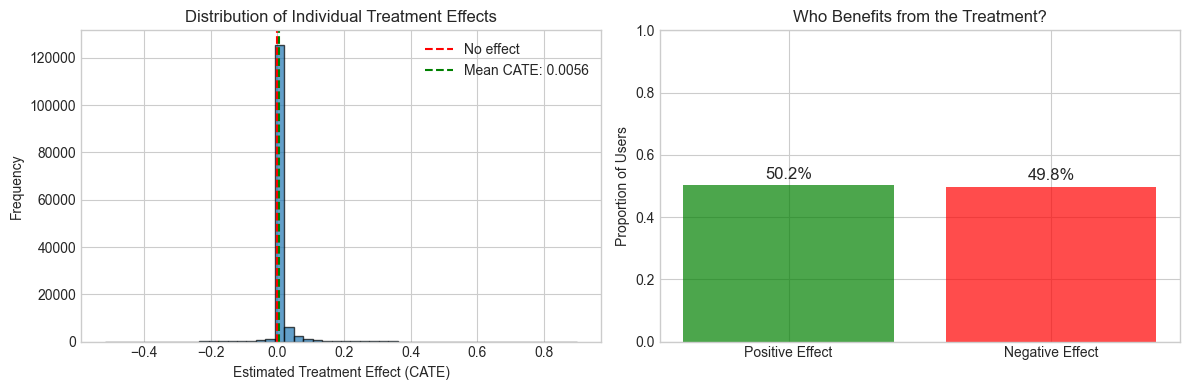


50.2% of users benefit from treatment
49.8% of users are harmed by treatment


In [12]:
# Visualize heterogeneity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of CATE
axes[0].hist(cate_estimates, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='No effect')
axes[0].axvline(x=np.mean(cate_estimates), color='green', linestyle='--', label=f'Mean CATE: {np.mean(cate_estimates):.4f}')
axes[0].set_xlabel('Estimated Treatment Effect (CATE)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Individual Treatment Effects')
axes[0].legend()

# What proportion benefits vs. is harmed?
positive_pct = (cate_estimates > 0).mean()
negative_pct = (cate_estimates < 0).mean()

axes[1].bar(['Positive Effect', 'Negative Effect'], [positive_pct, negative_pct], color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Proportion of Users')
axes[1].set_title('Who Benefits from the Treatment?')
axes[1].set_ylim(0, 1)

for i, pct in enumerate([positive_pct, negative_pct]):
    axes[1].text(i, pct + 0.02, f'{pct:.1%}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n{positive_pct:.1%} of users benefit from treatment")
print(f"{negative_pct:.1%} of users are harmed by treatment")

### 💡 Interview Insight: Interpreting HTE Results

*"The ATE is positive, but many users are harmed. What do you recommend?"*

**This is where judgment matters more than formulas.**

**Possible answers** (there's no single correct one):

1. **Ship to everyone** if the aggregate benefit outweighs harm, and targeting isn't practical.

2. **Target only positive responders** if:
   - You can identify them reliably
   - Targeting is operationally feasible
   - Marginal cost of targeting is low

3. **Hold for more investigation** if:
   - The harm seems too high
   - You don't understand WHY some users are harmed
   - Targeting would be expensive or error-prone

The key is showing you can reason through trade-offs, not just report numbers.

---

In [13]:
# Analyze targeting opportunity
# If we only treated positive responders, what would the effect be?
positive_mask = cate_estimates > 0
mean_positive_cate = cate_estimates[positive_mask].mean()
mean_negative_cate = cate_estimates[~positive_mask].mean()

print("Targeting Analysis")
print("=" * 50)
print(f"\nOverall ATE: {np.mean(cate_estimates):.6f}")
print(f"\nIf we target only positive responders ({positive_pct:.1%} of users):")
print(f"  Average effect: {mean_positive_cate:.6f}")
print(f"  Lift vs. ATE: {(mean_positive_cate / np.mean(cate_estimates) - 1):.1%}")
print(f"\nNegative responders we'd avoid ({negative_pct:.1%} of users):")
print(f"  Average effect: {mean_negative_cate:.6f}")

Targeting Analysis

Overall ATE: 0.005551

If we target only positive responders (50.2% of users):
  Average effect: 0.014019
  Lift vs. ATE: 152.5%

Negative responders we'd avoid (49.8% of users):
  Average effect: -0.002983


---

## Phase 5: Sequential Testing (Early Stopping)

### 💡 Interview Insight: The Peeking Problem

A common interview question: *"Your stakeholders want to check results daily. Is that okay?"*

**The problem**: Repeated testing inflates Type I error.

| Checks | False Positive Rate |
|--------|---------------------|
| 1 (end only) | 5% |
| 5 | ~14% |
| 20 | ~25% |
| 100 | ~33% |

**The solution**: Sequential testing with adjusted boundaries.

### O'Brien-Fleming Boundaries

O'Brien-Fleming is conservative early and permissive late:
- Hard to stop early (protects against false positives)
- Easy to stop at planned end (maintains power)

**Industry Practice**:
- Microsoft: Analyzes daily with sequential boundaries
- Netflix: Uses early stopping for harmful experiments
- LinkedIn: O'Brien-Fleming for most tests

---

In [14]:
# Generate O'Brien-Fleming boundaries
n_looks = 5  # We'll check 5 times during the experiment

# Correct parameter: two_sided (not one_sided)
boundaries = sequential.obrien_fleming_boundaries(
    n_looks=n_looks,
    alpha=0.05,
    two_sided=True
)

print("O'Brien-Fleming Boundaries")
print("=" * 50)
print(f"\nTotal looks: {n_looks}")
print(f"Overall alpha: 0.05")
print(f"\n{'Look':<6} {'Information':<15} {'Z-boundary':>12}")
print("-" * 40)

# Correct key: 'boundaries' (not 'z_boundaries')
for i in range(n_looks):
    info_frac = (i + 1) / n_looks
    z_bound = boundaries['boundaries'][i]
    print(f"{i+1:<6} {info_frac:<15.0%} {z_bound:>12.3f}")

O'Brien-Fleming Boundaries

Total looks: 5
Overall alpha: 0.05

Look   Information       Z-boundary
----------------------------------------
1      20%                    4.383
2      40%                    3.099
3      60%                    2.530
4      80%                    2.191
5      100%                   1.960


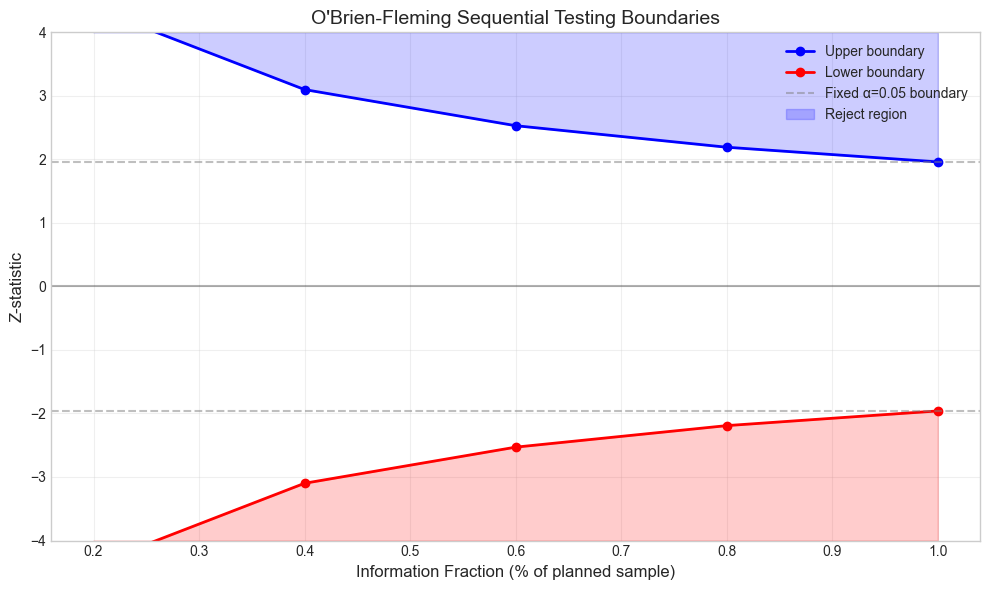


Interpretation:
- Early in experiment: Need very strong evidence to stop (Z > 4)
- At planned end: Normal threshold (Z ≈ 2)
- This controls overall Type I error at 5%


In [15]:
# Visualize the boundaries
fig, ax = plt.subplots(figsize=(10, 6))

info_fractions = [(i + 1) / n_looks for i in range(n_looks)]
# Correct key: 'boundaries' (not 'z_boundaries')
z_bounds = boundaries['boundaries']

# Plot boundaries
ax.plot(info_fractions, z_bounds, 'b-o', label='Upper boundary', linewidth=2)
ax.plot(info_fractions, [-z for z in z_bounds], 'r-o', label='Lower boundary', linewidth=2)

# Add reference lines
ax.axhline(y=1.96, color='gray', linestyle='--', alpha=0.5, label='Fixed α=0.05 boundary')
ax.axhline(y=-1.96, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Fill regions
ax.fill_between(info_fractions, z_bounds, [4]*n_looks, alpha=0.2, color='blue', label='Reject region')
ax.fill_between(info_fractions, [-z for z in z_bounds], [-4]*n_looks, alpha=0.2, color='red')

ax.set_xlabel('Information Fraction (% of planned sample)', fontsize=12)
ax.set_ylabel('Z-statistic', fontsize=12)
ax.set_title('O\'Brien-Fleming Sequential Testing Boundaries', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(-4, 4)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Early in experiment: Need very strong evidence to stop (Z > 4)")
print("- At planned end: Normal threshold (Z ≈ 2)")
print("- This controls overall Type I error at 5%")

In [16]:
# Simulate checking our experiment at each look
# We'll use the current z-statistic from our visit rate analysis
# z = effect / SE, where SE = CI width / (2 * 1.96)
se_estimate = (visit_result['ci_upper'] - visit_result['ci_lower']) / (2 * 1.96)
current_z = visit_result['absolute_lift'] / se_estimate

print("Sequential Testing Decision")
print("=" * 50)
print(f"\nCurrent z-statistic: {current_z:.3f}")
print(f"\nAssuming we're at look 3 of 5 (60% information):")

look = 3
# Correct key: 'boundaries' (not 'z_boundaries')
boundary = boundaries['boundaries'][look - 1]

print(f"  Boundary at look 3: ±{boundary:.3f}")
print(f"  Current z: {current_z:.3f}")

if abs(current_z) > boundary:
    print(f"\n  Decision: STOP - Effect crossed boundary")
    if current_z > boundary:
        print("  Conclusion: Treatment has significant POSITIVE effect")
    else:
        print("  Conclusion: Treatment has significant NEGATIVE effect")
else:
    print(f"\n  Decision: CONTINUE - Z-statistic within boundaries")
    print("  Continue to next interim analysis.")

Sequential Testing Decision

Current z-statistic: 6.031

Assuming we're at look 3 of 5 (60% information):
  Boundary at look 3: ±2.530
  Current z: 6.031

  Decision: STOP - Effect crossed boundary
  Conclusion: Treatment has significant POSITIVE effect


### 💡 Interview Insight: Sequential Testing Trade-offs

*"What are the downsides of sequential testing?"*

| Benefit | Cost |
|---------|------|
| Stop early if clear winner/loser | Slightly lower power for fixed-sample test |
| Protect users from harmful treatments | More complex analysis |
| Satisfy stakeholder impatience | Requires pre-specification |

**When to use sequential testing**:
- High-stakes decisions where early stopping matters
- Treatments that could be harmful
- Long-running experiments with multiple stakeholders

**When NOT to use it**:
- Short experiments where you'll just wait anyway
- When you need maximum power
- When analysis infrastructure is limited

---

## Phase 6: Guardrails and Final Decision

Even with advanced techniques, the decision framework remains the same:

| Decision | Criteria |
|----------|----------|
| **SHIP** | Primary positive + guardrails pass + acceptable HTE |
| **ABANDON** | Primary negative OR guardrails fail OR unacceptable harm |
| **HOLD** | Inconclusive OR need more investigation |

---

In [17]:
# Final decision synthesis
print("\n" + "=" * 60)
print("EXPERIMENT SYNTHESIS")
print("=" * 60)

print("\n📊 PRIMARY METRIC (Visit Rate):")
print(f"   Basic z-test: {visit_result['relative_lift']:.2%} lift (p={visit_result['p_value']:.4f})")
# Use correct key: effect_adjusted (not ate)
print(f"   CUPAC:        {cupac_result['effect_adjusted']:.6f} effect (p={cupac_result['p_value']:.4f})")
print(f"   Variance reduction: {cupac_result['var_reduction']:.1%}")

print("\n🎯 HETEROGENEITY (X-Learner):")
print(f"   {positive_pct:.1%} of users benefit from treatment")
print(f"   {negative_pct:.1%} of users are harmed")
print(f"   Targeting opportunity: {(mean_positive_cate / np.mean(cate_estimates) - 1):.1%} lift improvement")

print("\n⏱️  SEQUENTIAL TESTING:")
print(f"   Current z: {current_z:.3f}")
print(f"   At look 3/5: {'Within boundaries' if abs(current_z) < boundary else 'Crossed boundary'}")

print("\n" + "=" * 60)
print("RECOMMENDATION")
print("=" * 60)

# This is where judgment comes in
if visit_result['significant'] and visit_result['relative_lift'] > 0:
    if negative_pct < 0.3:  # Less than 30% harmed
        print("\n✅ SHIP to all users")
        print("   - Primary metric positive")
        print("   - Majority of users benefit")
    else:
        print("\n⚪ CONSIDER TARGETING")
        print("   - Primary metric positive overall")
        print(f"   - But {negative_pct:.1%} harmed—explore targeted rollout")
elif visit_result['significant'] and visit_result['relative_lift'] < 0:
    print("\n❌ ABANDON")
    print("   - Treatment has negative effect")
else:
    print("\n⚪ HOLD")
    print("   - Results not conclusive")
    print("   - Continue data collection")


EXPERIMENT SYNTHESIS

📊 PRIMARY METRIC (Visit Rate):
   Basic z-test: 22.55% lift (p=0.0000)
   CUPAC:        0.006234 effect (p=0.0000)
   Variance reduction: 30.8%

🎯 HETEROGENEITY (X-Learner):
   50.2% of users benefit from treatment
   49.8% of users are harmed
   Targeting opportunity: 152.5% lift improvement

⏱️  SEQUENTIAL TESTING:
   Current z: 6.031
   At look 3/5: Crossed boundary

RECOMMENDATION

⚪ CONSIDER TARGETING
   - Primary metric positive overall
   - But 49.8% harmed—explore targeted rollout


---

## Summary: When to Use Advanced Techniques

| Technique | Use When | Don't Use When |
|-----------|----------|----------------|
| **CUPAC** | Large samples, rich covariates, need precision | Small samples, limited features |
| **X-Learner** | Personalization, targeting decisions | Just need ATE, limited data |
| **Sequential** | Long experiments, early stopping valuable | Short experiments, max power needed |

### Key Takeaways for Interviews

1. **Advanced techniques are tools, not goals.** Know WHEN to use them.

2. **Trade-offs are everywhere.** CUPAC vs. CUPED, targeting vs. broad rollout.

3. **Judgment > formulas.** The hardest part isn't running the code—it's deciding what to do.

4. **Heterogeneity changes decisions.** ATE positive but many harmed = different conversation.

5. **Sequential testing enables agility.** But requires upfront planning.

---

## 🎓 Exercises for Practice

### Exercise 1: CUPED vs. CUPAC Comparison
Implement CUPED using a single pre-experiment covariate. Compare variance reduction to CUPAC.

### Exercise 2: Targeting Strategy
Build a classifier to identify positive responders. What's the precision/recall trade-off for targeting?

### Exercise 3: Interview Practice
Explain to an interviewer: *"Why did you use X-Learner instead of just subsetting the data by user characteristics?"*

---

**Next Notebook**: [03_marketing_complete_workflow.ipynb](03_marketing_complete_workflow.ipynb) - Complete end-to-end workflow with data quality, power analysis, novelty effects, and business impact calculation.